In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc, norm
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples
matplotlib.rc('font', size=14,family='serif')
matplotlib.rc('legend', fontsize=14)

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1716.39it/s, 7 steps of size 4.37e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.68s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      4.47      6.07      1.97      0.14     13.75     46.11      0.97
        kernel_length[0]      1.31      0.83      1.30      0.22      2.52     39.83      1.02
            kernel_tausq      1.38      3.82      0.41      0.02      2.56     33.27      1.02
              kernel_var     16.46     12.46     10.98      2.56     29.92     20.31      1.01

Number of divergences: 0


In [3]:
### plotting functions

def plot_gp(test_x,ax):
    mu, var = gp.posterior(test_x,single=True)
    std = jnp.sqrt(var)
    ax.plot(test_x,test_y,label='True',color='k')
    ax.scatter(train_x,train_y,color='k')
    ax.plot(test_x,mu,label='GP')
    ax.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
    ax.set(xlabel=r'$x$',ylabel=r'$f(x)$')
    ax.legend()

def plot_hyperparams(gp,fig,ax):
    colors = matplotlib.colormaps['YlGn']
    l = np.array(gp.samples["kernel_length"].squeeze(-1))
    o = np.array(gp.samples["kernel_var"])
    lp = -np.array(gp.samples["minus_log_prob"])
    lp_min, lp_max = np.min(lp), np.max(lp)
    cols = np.linspace(lp_min,lp_max,len(lp))
    cols = (cols - lp_min)/(lp_max - lp_min)
    ax.scatter(l,o)
    sc = ax.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
    fig.colorbar(sc,ax=ax)
    ax.set(xlabel=r'lengthscale',ylabel=r'outputscale')

def plot_acq(acq_x,acq_vals,next_x,next_val,mc_points,gp,ax):
    ax.plot(acq_x,acq_vals)
    ax.scatter(next_x,next_val,color='r',label=r'next point')
    ax.set(xlabel=r'$x$',ylabel=r'$\mathrm{IPV}(x)$')
    _, pre_var = gp.posterior(mc_points,unstandardize=False)
    pre_var = pre_var.mean()
    for pt in gp.train_x:
        ax.axvline(pt,color='k',ls='-.',lw=0.5)
        ax.axhline(pre_var,color='k',lw=1)
    ax.legend()

INFO:[NS]: Nested Sampling took 1.98s
INFO:[NS]: jaxns did 797 likelihood evaluations


LogZ infologz_mean: = -3.2616, dlogz: = 0.1101, 


INFO:[AQ]: Acquisition optimization took 0.82 s


Next point at x = [0.62345969] with acquisition function value = 0.023467941045895696


sample: 100%|██████████| 384/384 [00:00<00:00, 814.28it/s, 15 steps of size 3.02e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 0.86s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.48s
INFO:[NS]: jaxns did 2236 likelihood evaluations


LogZ infologz_mean: = -1.2302, dlogz: = 0.2750, 


INFO:[AQ]: Acquisition optimization took 1.00 s


Next point at x = [0.45216549] with acquisition function value = 0.3659557601518153


sample: 100%|██████████| 384/384 [00:00<00:00, 810.55it/s, 3 steps of size 5.89e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.10s
INFO:[NS]: jaxns did 2480 likelihood evaluations


LogZ infologz_mean: = -0.3719, dlogz: = 0.2852, 


INFO:[AQ]: Acquisition optimization took 1.19 s


Next point at x = [0.51272207] with acquisition function value = 0.11540863404039146


sample: 100%|██████████| 384/384 [00:00<00:00, 802.48it/s, 7 steps of size 5.10e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.80s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.20s
INFO:[NS]: jaxns did 2702 likelihood evaluations


LogZ infologz_mean: = -0.1364, dlogz: = 0.2728, 


INFO:[AQ]: Acquisition optimization took 0.84 s


Next point at x = [0.8340329] with acquisition function value = 0.0002714220442508325


sample: 100%|██████████| 384/384 [00:00<00:00, 816.91it/s, 7 steps of size 7.47e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 0.75s


----------------------Step 4 complete----------------------

BO took 15.00 s 


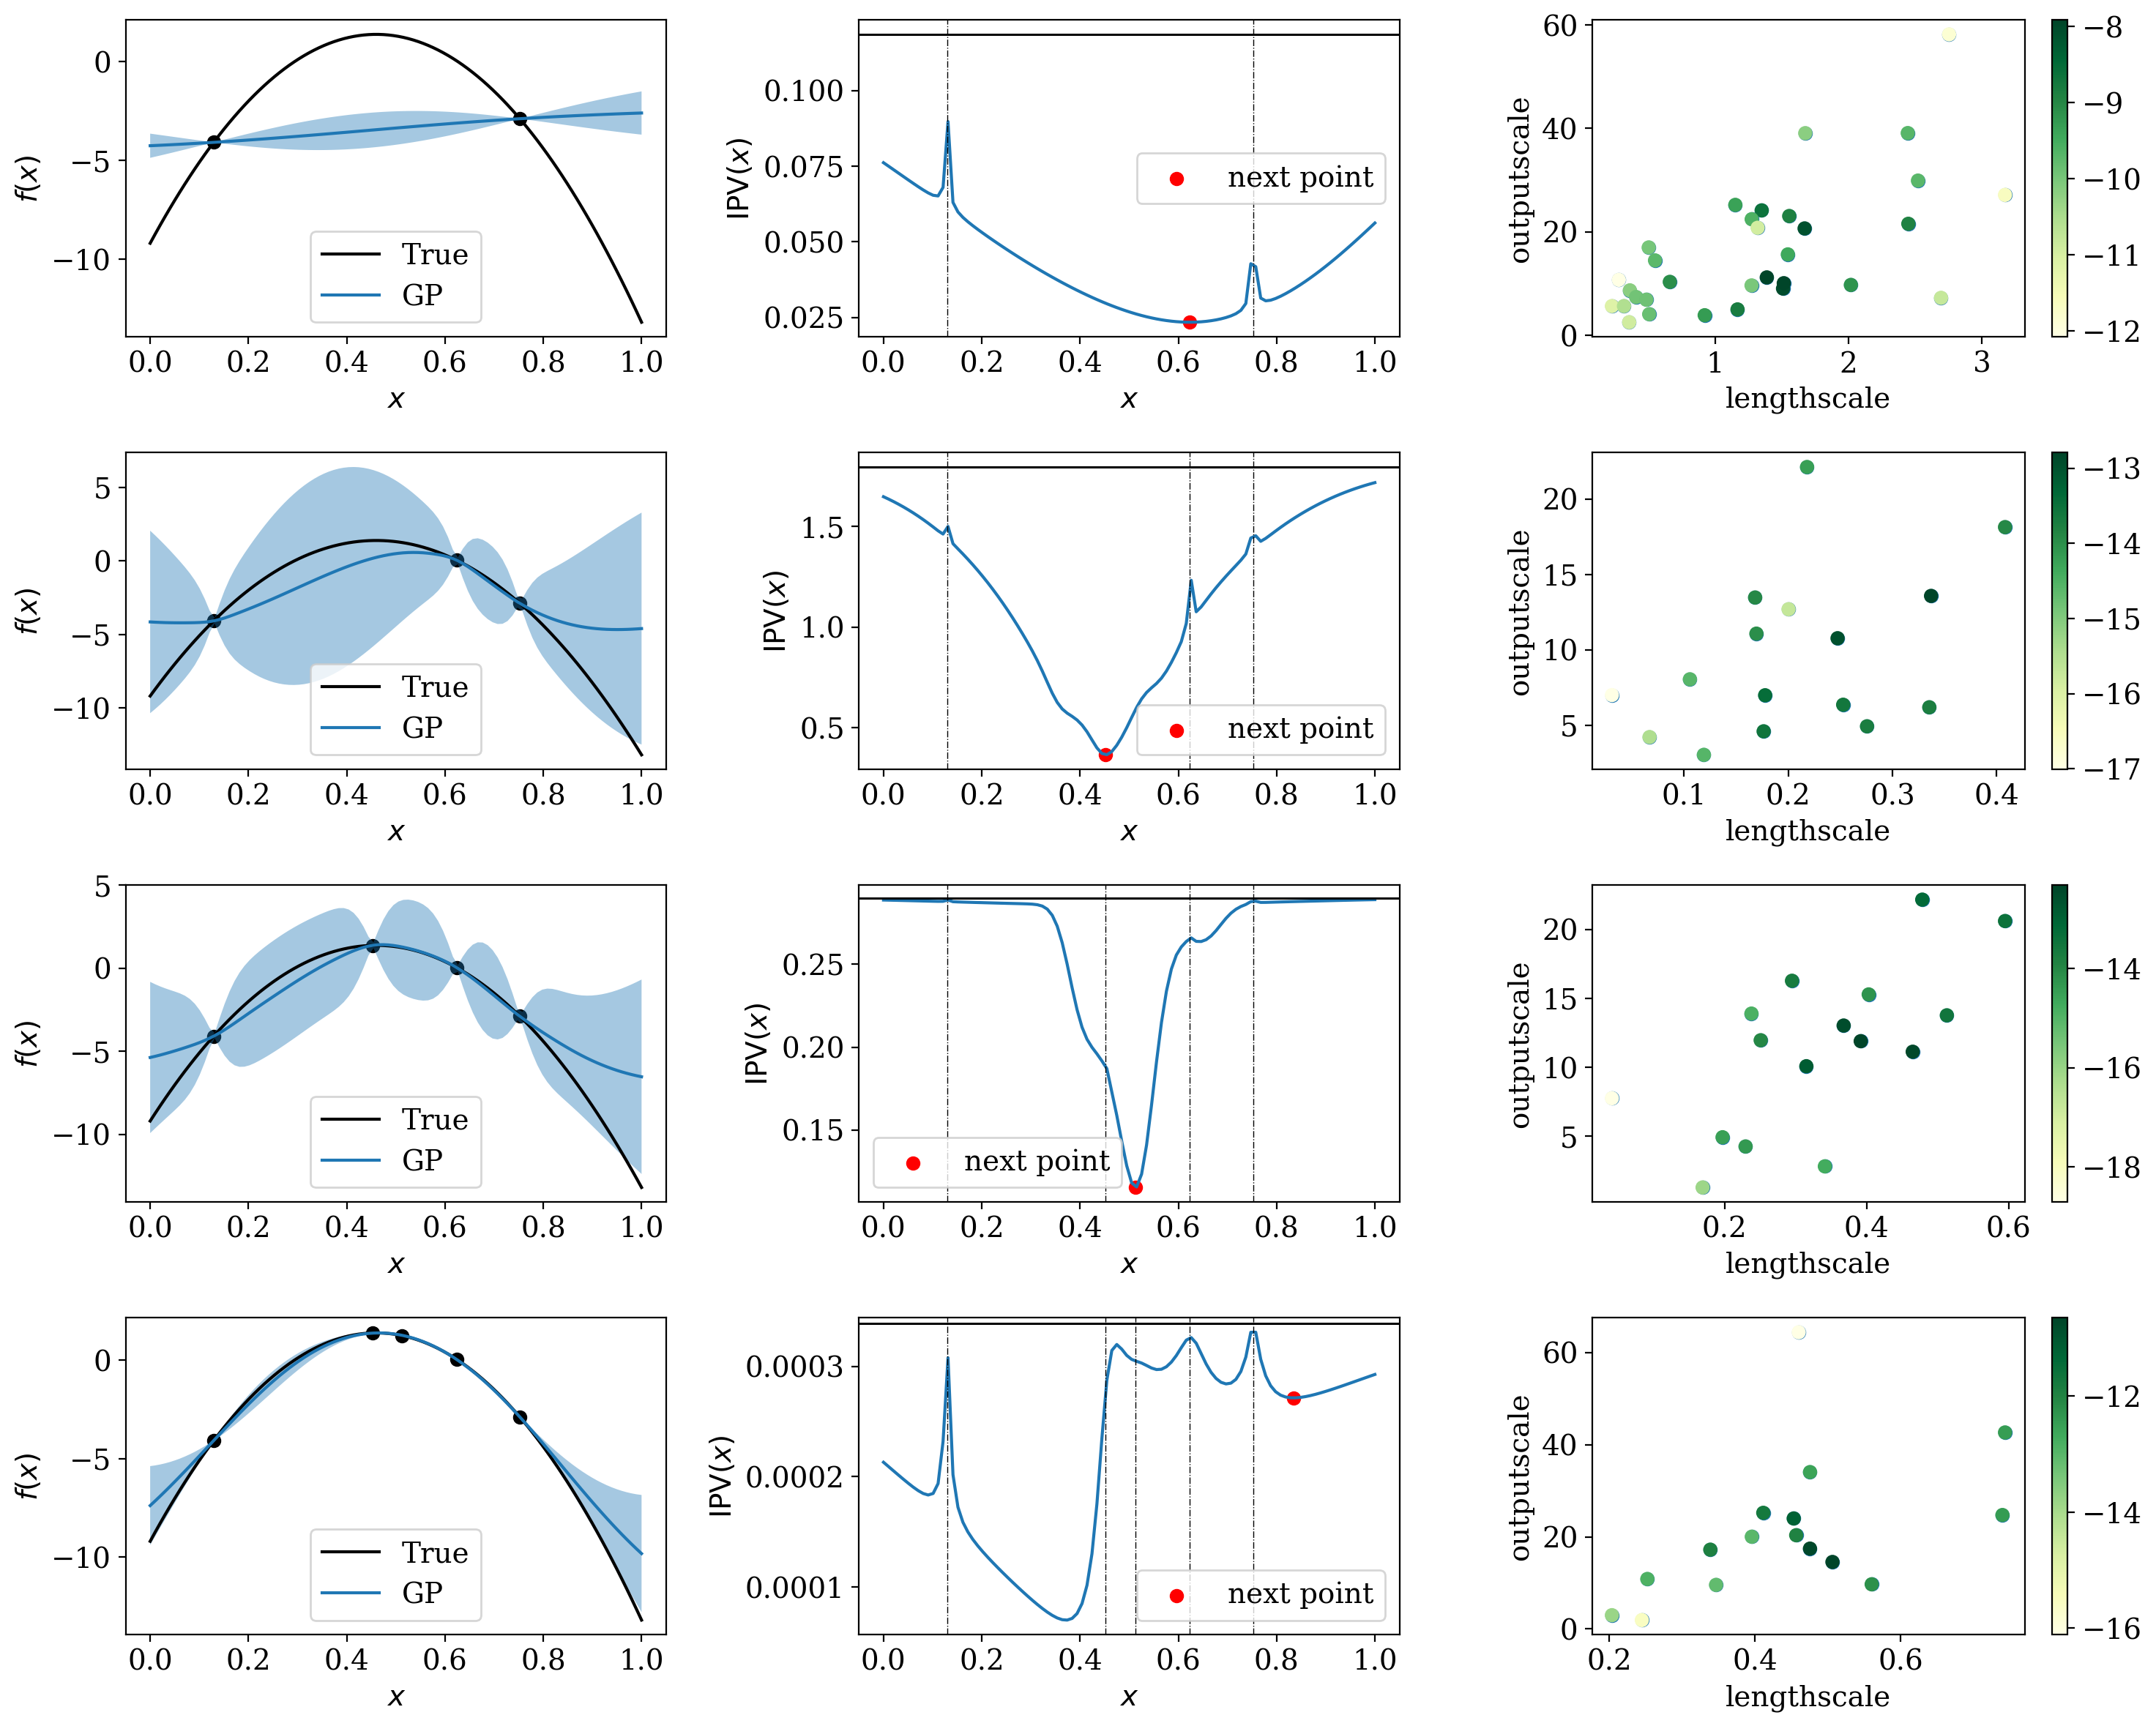

In [4]:
nsteps = 4 # 32
mc_points_size = 8

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps))
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = IPV(gp,mc_points)  # EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform()
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
    gp = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()

In [5]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.0001,num_samples_equal=1000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 2.39s
INFO:[NS]: jaxns did 148321 likelihood evaluations


LogZ info: logz_mean: = 0.0735, dlogz: = 0.1477, 


Removed no burn in
Removed no burn in


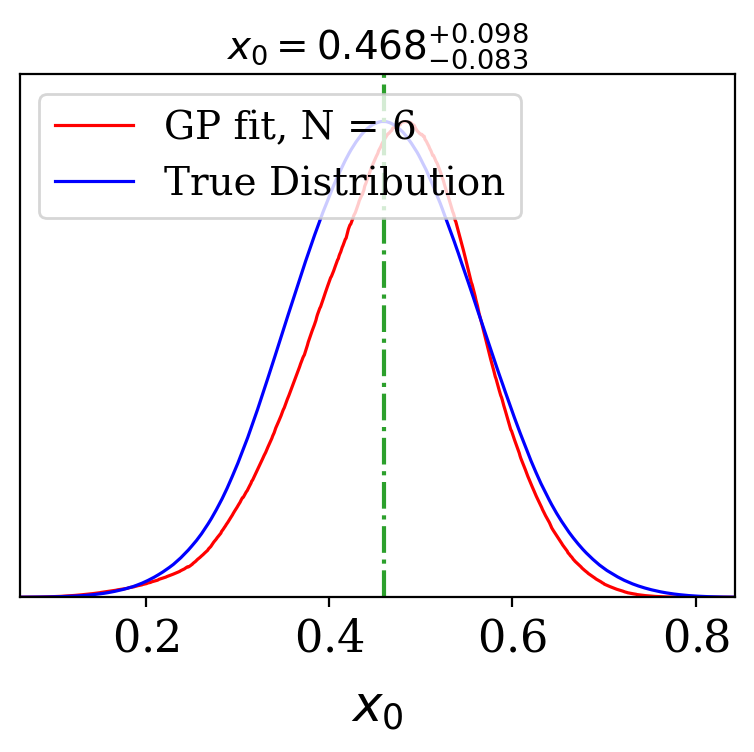

In [6]:
test_samples = np.random.normal(loc=f_mean,scale=scale,size=int(1e4))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=4,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.plot_1d([gp_samples,true_samples],'x_0',filled=[True,False],colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],title_limit=1) # type: ignore
g.add_legend([f'GP fit, N = {gp.train_y.shape[0]}','True Distribution'],legend_loc='upper left')
for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean, color='C2', ls='-.')


In [5]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 2
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = 0.46
scale = 0.1
d =  norm(loc= f_mean,scale=scale)

f = lambda x: d.logpdf(x) #mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

(2, 1) (2, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1825.41it/s, 7 steps of size 4.34e-01. acc. prob=0.95]
INFO:[GP]: MCMC elapsed time: 0.63s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     22.00     92.24      3.72      0.22     13.56     35.71      1.00
        kernel_length[0]      0.97      0.56      0.99      0.12      1.60     47.04      0.97
            kernel_tausq      0.97      1.50      0.43      0.03      2.15     16.52      1.00
              kernel_var     14.20     12.70     10.65      2.04     29.78     20.67      0.97

Number of divergences: 0


INFO:[NS]: Nested Sampling took 0.99s
INFO:[NS]: jaxns did 1440 likelihood evaluations


LogZ infologz_mean: = -0.6118, dlogz: = 0.2302, 


INFO:[AQ]: Acquisition optimization took 0.52 s


Next point at x = [0.11483273] with acquisition function value = 0.06432014460455296


sample: 100%|██████████| 384/384 [00:00<00:00, 759.49it/s, 7 steps of size 4.05e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.55s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.12s
INFO:[NS]: jaxns did 2251 likelihood evaluations


LogZ infologz_mean: = -1.4506, dlogz: = 0.2604, 


INFO:[AQ]: Acquisition optimization took 0.85 s


Next point at x = [0.40501706] with acquisition function value = 0.6679224320391196


sample: 100%|██████████| 384/384 [00:00<00:00, 757.74it/s, 15 steps of size 4.92e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 0.56s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.03s
INFO:[NS]: jaxns did 2476 likelihood evaluations


LogZ infologz_mean: = -0.4346, dlogz: = 0.2855, 


INFO:[AQ]: Acquisition optimization took 0.49 s


Next point at x = [0.58461788] with acquisition function value = 0.054105286872475844


sample: 100%|██████████| 384/384 [00:00<00:00, 786.60it/s, 7 steps of size 5.22e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 0.55s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 1.05s
INFO:[NS]: jaxns did 2614 likelihood evaluations


LogZ infologz_mean: = -0.1303, dlogz: = 0.2762, 


INFO:[AQ]: Acquisition optimization took 0.46 s


Next point at x = [0.52252412] with acquisition function value = 0.0007264937949799655


sample: 100%|██████████| 384/384 [00:00<00:00, 789.54it/s, 7 steps of size 8.68e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.55s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 1.04s
INFO:[NS]: jaxns did 2481 likelihood evaluations


LogZ infologz_mean: = -0.1053, dlogz: = 0.2720, 


INFO:[AQ]: Acquisition optimization took 0.67 s


Next point at x = [0.66927663] with acquisition function value = 6.656819318368035e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 811.06it/s, 7 steps of size 6.65e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 0.80s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 1.22s
INFO:[NS]: jaxns did 2492 likelihood evaluations


LogZ infologz_mean: = -0.1060, dlogz: = 0.2717, 


INFO:[AQ]: Acquisition optimization took 0.73 s


Next point at x = [0.42631262] with acquisition function value = 5.1071416904281686e-05


sample: 100%|██████████| 384/384 [00:00<00:00, 792.54it/s, 7 steps of size 7.82e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.78s


----------------------Step 6 complete----------------------

BO took 15.08 s 


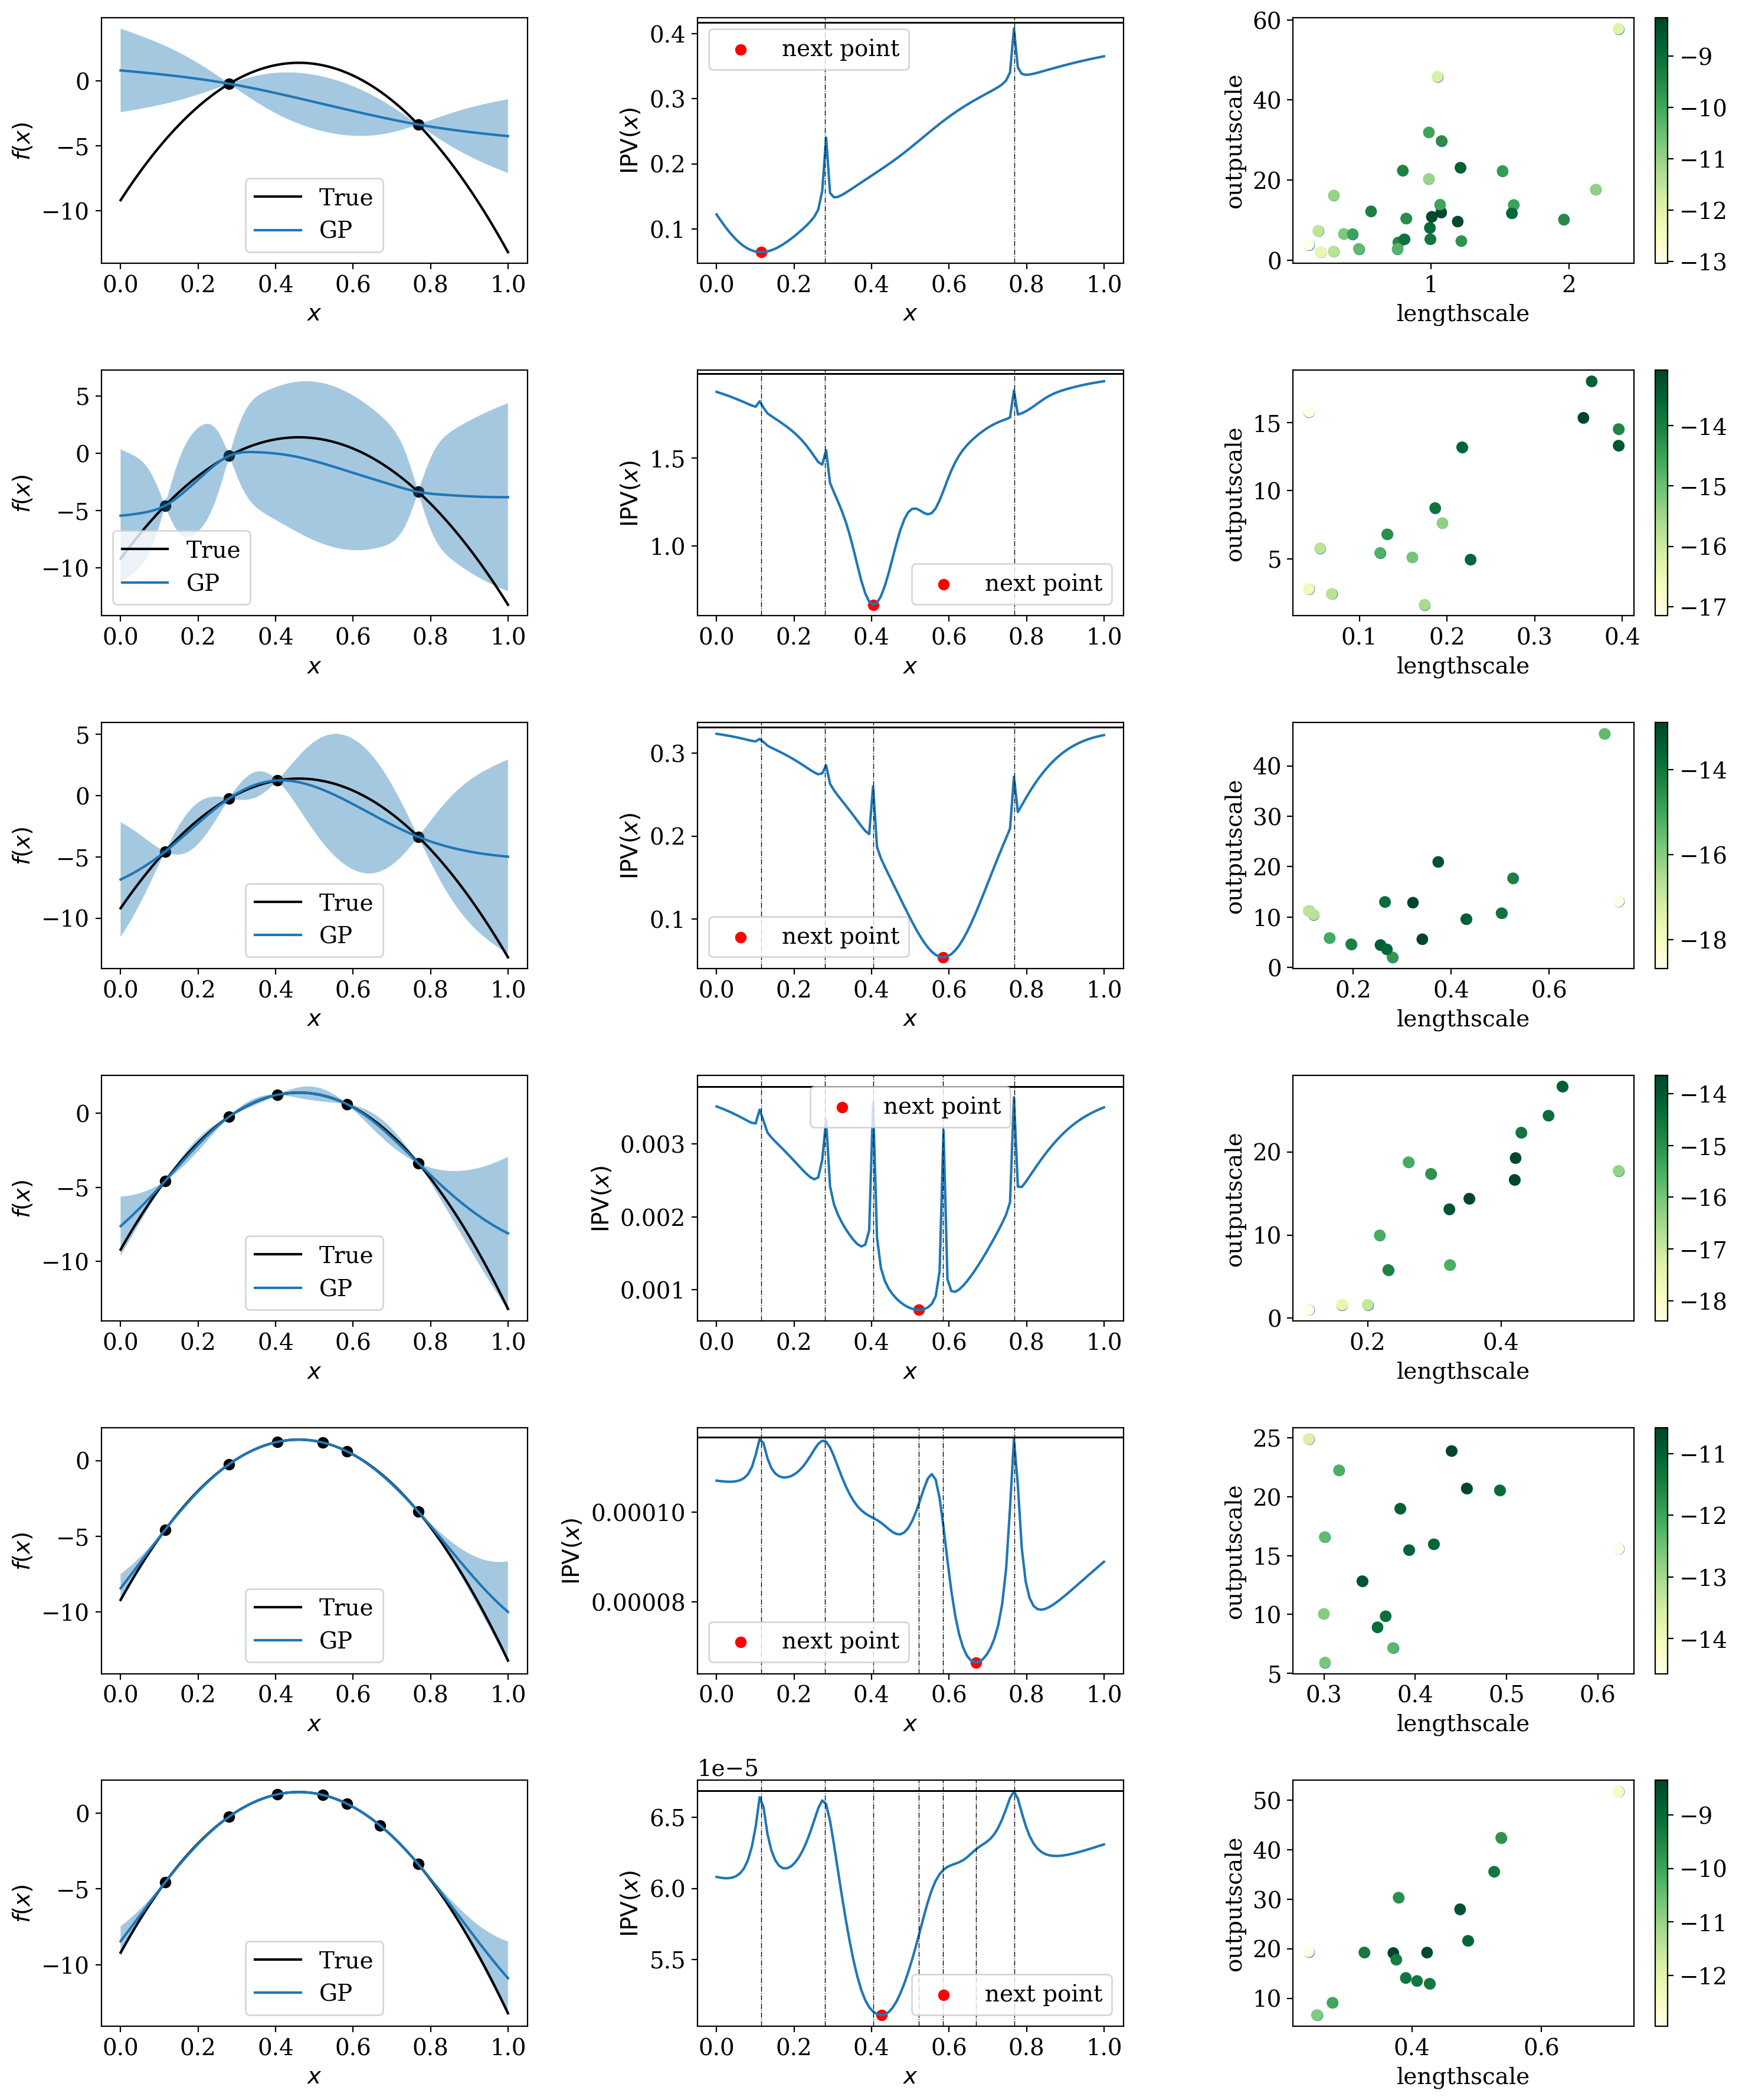

In [6]:
nsteps = 6 # 32
mc_points_size = 8

fig, ax = plt.subplots(nsteps,3,figsize=(15,3*nsteps))
start = time.time()
for i in range(nsteps):
    plot_gp(test_x,ax[i,0])
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    plot_hyperparams(gp,fig,ax[i,2])
    print(f"LogZ info"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    mc_points = samples[:mc_points_size,:]
    acq_func = IPV(gp,mc_points)  # EI(gp,gp.train_y.max()) 
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform()
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    acq_vals = vmap(acq_func)(test_x)
    # print(acq_vals.shape)
    plot_acq(test_x,acq_vals,next_x,results.fun,mc_points=mc_points,gp=gp,ax=ax[i,1])
     # = saas_fbgp(train_x,train_y,noise=1e-4)
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    #gp.fit(rng_key,warmup_steps=256,num_samples=128,thinning=8,verbose=False)
    gp.update(next_x,next_y,rng_key)

    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")
fig.tight_layout()